# Make a slabs_iter

In [1]:
# from the documentation of slabs 

from meshed.slabs import Slabs

from statistics import stdev
vol = stdev
should_turn_movement_sensor_on = lambda audio, light: vol(audio) * light > 50000

def make_a_slabs_iter():

    # Mocking the sensor readers
    audio_sensor_read = iter([[1, 2, 3], [-96, 87, -92], [320, -96, 99]]).__next__
    light_sensor_read = iter([126, 501, 523]).__next__
    movement_sensor_read = iter([None, None, True]).__next__

    return Slabs(
        # The first three components get data from the sensors.
        # The *_read objects are all callable, returning the next
        # chunk of data for that sensor, if any.
        audio=audio_sensor_read,
        light=light_sensor_read,
        movement=movement_sensor_read,
        # The next
        should_turn_movement_sensor_on = lambda audio, light: vol(audio) * light > 50000,
        human_presence_score = lambda audio, light, movement: movement and sum([vol(audio), light]),
        should_notify = lambda human_presence_score: human_presence_score and human_presence_score > 700,
        notify = lambda should_notify: print('someone is there') if should_notify else None
    )


si = make_a_slabs_iter()
next(si)  
    

{'audio': [1, 2, 3],
 'light': 126,
 'movement': None,
 'should_turn_movement_sensor_on': False,
 'human_presence_score': None,
 'should_notify': None,
 'notify': None}

In [2]:
next(si)

{'audio': [-96, 87, -92],
 'light': 501,
 'movement': None,
 'should_turn_movement_sensor_on': True,
 'human_presence_score': None,
 'should_notify': None,
 'notify': None}

# Slabs for stamping press

In [3]:
#Valentin's code
from dataclasses import dataclass
from typing import Iterator
from creek.infinite_sequence import BufferedGetter, OverlapsPastError
from itertools import islice


@dataclass
class TimestampedInfiniteSequence:

    iterator: Iterator
    buffer_len: int

    def __post_init__(self):
        self.buffer_getter = BufferedGetter(self.buffer_len)

    def __getitem__(self, item):
        if isinstance(item, slice):
            items = list(self.buffer_getter)
            
            if not len(items):
                self.buffer_getter.extend(islice(self.iterator, 1))
                return self.__getitem__(item)
            #buffer = AudioData.concatenate(items)
            if item.stop > items[-1]['ts']: #item must have a ts attribute
                self.buffer_getter.extend(islice(self.iterator, 1))
                return self.__getitem__(item)
            if item.start < items[0]['ts']:
                raise OverlapsPastError(
                    f'wrong range'
                    #f'You asked for {item}, but the buffer only contains the index range: {items.start_date}:{items.end_date}'
                )
            
            def query(i: dict):
                #print(f'{item.start=}, {item.stop=}, {i["ts"]=}')
                return item.start <= i['ts'] < item.stop
            
            return self.buffer_getter[query]
        elif isinstance(item, int):
            return self[slice(item, item + 1)][0]

In [4]:
from meshed.slabs import Slabs
from more_itertools import windowed

from typing import Callable

last_plc = None
def filter_on_predicate(data, pred: Callable, event):
    if event is None:
        return 'out1'
    if pred(event):
        return data
    else: 
        return 'out1'

def event_switch(event):
    event['event_a']

def demux(accel, plc):
    result = 'out_1'
    if plc['event_a']:
        result = accel
    return filter_on_predicate(accel, event_switch, plc)


def my_iterator(obj, step = 10):
    for i in range(0, 30, step):
        print(f'{i=}, {i+step=}')
        yield obj[i:i+step]

def make_a_slabs_iter():
    # Sensor readers, slabs of 1 sec
    # use next_slice of creek InfiniteStream instead of iter
    #accelerometer_sensor_read = iter([{'ch1':1, 'ch2':2, 'ch3':3, 'ts':001}, {'ch1':-2, 'ch2':22, 'ch3':43, 'ts':002},
    #                                  {'ch1':92, 'ch2':94, 'ch3':95, 'ts':003}]).__next__
    accelerometer_sensor_read = iter([{'ch1':1, 'ch2':2, 'ch3':3, 'ts':0},{'ch1':1, 'ch2':2, 'ch3':3, 'ts':10}, 
                                             {'ch1':-2, 'ch2':22, 'ch3':43, 'ts':20},{'ch1':92, 'ch2':94, 'ch3':95, 'ts':30},
                                             {'ch1':92, 'ch2':94, 'ch3':95, 'ts':40}])
    accel_buffer = my_iterator(TimestampedInfiniteSequence(accelerometer_sensor_read, buffer_len = 2)).__next__

    # change to an iterator on slices, from 10 to 10
    plc_read = iter([{'var_a':False, 'var_b':False,'ts':0},{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':10}, 
                        {'var_a':True, 'var_b':True,'ts':15},{'var_a':True, 'var_b':True,'ts':20},
                        {'var_a':True, 'var_b':True,'ts':25},{'var_a':False, 'var_b':True,'ts':30},
                        {'var_a':False, 'var_b':True,'ts':35},{'var_a':False, 'var_b':True,'ts':40}])
    plc_buffer = my_iterator(TimestampedInfiniteSequence(plc_read, buffer_len = 3)).__next__
    
    # pb: what to do with different sample rates? events at the same time! {event_a, event_b}
    return Slabs(
        accel=accel_buffer,
        plc=plc_buffer,
        store_last_plc = lambda plc: set_last_plc(plc[-1]),
        plc_event= lambda plc: list(detect_difference(plc)),
        #demux = lambda accel, plc: filter_on_predicate(accel, event_switch, plc),
        #buffer = lambda demux: windowed(demux, n=2)
    )

def detect_difference(arr):
    if last_plc['var_a'] != arr[0]['var_a']:
        yield 'event_a'
    for x,y in zip(arr, arr[1:]):
        if x['var_a'] != y['var_a']:
            yield 'event_a'

def set_last_plc(value):
    global last_plc    
    last_plc = value



s = make_a_slabs_iter()
next(s)
#next(s)

i=0, i+step=10
i=0, i+step=10


{'accel': [{'ch1': 1, 'ch2': 2, 'ch3': 3, 'ts': 0}],
 'plc': [{'var_a': False, 'var_b': False, 'ts': 0},
  {'var_a': False, 'var_b': False, 'ts': 5}],
 'store_last_plc': None,
 'plc_event': []}

In [5]:
next(s)

i=10, i+step=20
i=10, i+step=20


{'accel': [{'ch1': 1, 'ch2': 2, 'ch3': 3, 'ts': 10}],
 'plc': [{'var_a': True, 'var_b': False, 'ts': 10},
  {'var_a': True, 'var_b': True, 'ts': 15}],
 'store_last_plc': None,
 'plc_event': []}

In [6]:
# sample rate must be the same
# events can occur at the same time
# Valentin: use creek

In [7]:
accelerometer_sensor_iter = iter([{'ch1':1, 'ch2':2, 'ch3':3, 'ts':0},{'ch1':1, 'ch2':2, 'ch3':3, 'ts':10}, {'ch1':-2, 'ch2':22, 'ch3':43, 'ts':20},{'ch1':92, 'ch2':94, 'ch3':95, 'ts':30},{'ch1':92, 'ch2':94, 'ch3':95, 'ts':40}])
accel_buffer = TimestampedInfiniteSequence(accelerometer_sensor_iter, buffer_len = 3)

#plc_sensor_iter = iter([{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':21}, {'var_a':False, 'var_b':True,'ts':32}])
plc_sensor_iter = iter([{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':10}, 
                        {'var_a':False, 'var_b':True,'ts':15},{'var_a':False, 'var_b':True,'ts':20},
                        {'var_a':False, 'var_b':True,'ts':25},{'var_a':False, 'var_b':True,'ts':30},
                        {'var_a':False, 'var_b':True,'ts':35},{'var_a':False, 'var_b':True,'ts':40}])

plc_buffer = TimestampedInfiniteSequence(plc_sensor_iter, buffer_len = 3)


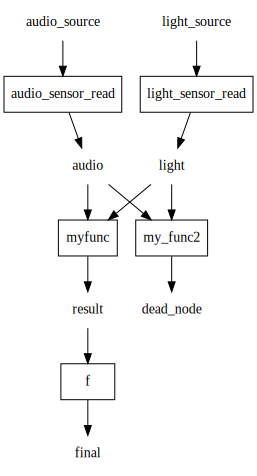

In [8]:
from meshed import code_to_dag

@code_to_dag
def user_story():
    audio = audio_sensor_read(audio_source)
    light = light_sensor_read(light_source)
    result = myfunc(audio, light)
    final = f(result)
    dead_node = my_func2(audio, light)
    

user_story.dot_digraph()

In [9]:
s = make_a_slabs_iter()

In [10]:
list(next(s)['buffer'])

i=0, i+step=10
i=0, i+step=10


KeyError: 'buffer'

# Using rxpy

In [11]:
import reactivex as rx
from reactivex import operators as ops


letters = rx.from_(["Alpha", "Beta", "Gamma", "Delta", "Epsilon"])
numbers = rx.from_([1,2,3,4,5])

ModuleNotFoundError: No module named 'reactivex'

In [12]:
numbers.subscribe(lambda x: print(x))

NameError: name 'numbers' is not defined

In [13]:
letters.pipe(ops.skip_until(numbers.subscribe(print))).subscribe(print)

# letters.pipe(ops.skip_until(lambda s: len(s)), ops.filter(lambda i: i >= 5)).subscribe(
#     lambda value: print("Received {0}".format(value))
# )

NameError: name 'letters' is not defined

# Using actual data

# plc data:  wav file
# channel data: wav file

In [14]:
# reactive programming in slabs
# start with reading the plc
# do  the async stuff
# you buffer the plc
# how to solve the backpressure problem?
# if None: we do not ignore the input (slabs is a function)
# handling the signals: check the notes
# in meshed: get exceptions

In [15]:
import soundfile as sf
from hear.tools import AudioSegments, AffineConverter

#segs = AudioSegments(src_to_wfsr=sf.read, index_to_seconds_scale=1 / 1e6) #index by microseconds
segs = AudioSegments(src_to_wfsr=sf.read, index_to_seconds_scale=1/50) #index by microseconds


In [16]:
# data
plc_filepath = 'data/PLC.wav'
accel_filepath = 'data/1621346260226336_ch2.wav'

In [17]:
# 59650 samples, at 50 hz = 1193 seconds, ie 19 minutes 53 seconds
plc_data = segs[plc_filepath]
len(plc_data)

59650

In [18]:
# we can query data with bt, tt
len(plc_data[0:1])


1

In [19]:
# from local data to generator

def my_iterator(obj, step = 10):
    for i in range(0, 30, step):
        print(f'{i=}, {i+step=}')
        yield obj[i:i+step]

def mk_data(filepath, channel_name='plc'):
    wf, sr = sf.read(filepath)
    
    index_to_seconds_scale = 1000*1 / sr
    index_to_seconds_offset = 0
    indexer = AffineConverter(
            scale=index_to_seconds_scale, offset=index_to_seconds_offset
        )
    for i, sample in enumerate(wf):
        yield {channel_name:sample, 'ts':indexer(i)}

In [20]:
plc_iter = mk_data(plc_filepath, channel_name='plc')
for i in range(10):
    print(next(plc_iter))

{'plc': 0.0, 'ts': 0.0}
{'plc': 0.0, 'ts': 20.0}
{'plc': 0.0, 'ts': 40.0}
{'plc': 0.0, 'ts': 60.0}
{'plc': 0.0, 'ts': 80.0}
{'plc': 0.0, 'ts': 100.0}
{'plc': 0.0, 'ts': 120.0}
{'plc': 0.0, 'ts': 140.0}
{'plc': 0.0, 'ts': 160.0}
{'plc': 0.0, 'ts': 180.0}


In [21]:
accel_iter = mk_data(accel_filepath, channel_name='accel')
for i in range(10):
    print(next(accel_iter))

{'accel': -0.035858154296875, 'ts': 0.0}
{'accel': -0.022705078125, 'ts': 0.078125}
{'accel': 0.004241943359375, 'ts': 0.15625}
{'accel': 0.0084228515625, 'ts': 0.234375}
{'accel': 0.000823974609375, 'ts': 0.3125}
{'accel': 0.00164794921875, 'ts': 0.390625}
{'accel': -0.01666259765625, 'ts': 0.46875}
{'accel': -0.00811767578125, 'ts': 0.546875}
{'accel': 0.00689697265625, 'ts': 0.625}
{'accel': -0.0010986328125, 'ts': 0.703125}


In [22]:
# check creek more carefully

In [23]:
accelerometer_sensor_read = mk_data(plc_filepath, channel_name='accel')
plc_sensor_read = mk_data(plc_filepath, channel_name='plc')


#slab[10:30]-> all that happens between 10 and 30
#slab[30:50]

plc_buffer = my_iterator(TimestampedInfiniteSequence(plc_sensor_read, buffer_len = 20), step =10)

    # # change to an iterator on slices, from 10 to 10
    # plc_read = iter([{'var_a':False, 'var_b':False,'ts':0},{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':10}, 
    #                     {'var_a':True, 'var_b':True,'ts':15},{'var_a':True, 'var_b':True,'ts':20},
    #                     {'var_a':True, 'var_b':True,'ts':25},{'var_a':False, 'var_b':True,'ts':30},
    #                     {'var_a':False, 'var_b':True,'ts':35},{'var_a':False, 'var_b':True,'ts':40}])
    # plc_buffer = my_iterator(TimestampedInfiniteSequence(plc_read, buffer_len = 3)).__next__
    
    # # pb: what to do with different sample rates? events at the same time! {event_a, event_b}
    # return Slabs(
    #     accel=accel_buffer,
    #     plc=plc_buffer,
    #     result=accel+plc
    #     store_last_plc = lambda plc: set_last_plc(plc[-1]),
    #     plc_event= lambda plc: list(detect_difference(plc)),
    #     #demux = lambda accel, plc: filter_on_predicate(accel, event_switch, plc),
    #     #buffer = lambda demux: windowed(demux, n=2)
    # )

In [24]:
plc_sensor_read = mk_data(plc_filepath, channel_name='plc')

ts_data = iter(TimestampedInfiniteSequence(plc_sensor_read, buffer_len = 200))


In [25]:
next(ts_data)

{'plc': 0.0, 'ts': 0.0}

## 

In [26]:
plc_sensor_read

<generator object mk_data at 0x7ff6bbc61a80>

In [27]:
list(plc_buffer)

i=0, i+step=10
i=10, i+step=20
i=20, i+step=30


[[{'plc': 0.0, 'ts': 0.0}], [], [{'plc': 0.0, 'ts': 20.0}]]

In [28]:
# change the step size to maybe 100ms
next(accel_buffer)

TypeError: 'TimestampedInfiniteSequence' object is not an iterator

In [29]:
plc_buffer = TimestampedInfiniteSequence(plc_sensor_iter, buffer_len = 3)


# Using Andie's stream

In [30]:
# careful to use floats with the wfs. 
# rescale the signal
# buffer: keep last two values of signal

In [57]:
def extract_edge_indices_from_bool_segment(bool_segment: np.ndarray, 
    last_sample_of_previous_segment: bool, edge_type: str) -> list:
    #bool_segment = np.diff(bool_segment, prepend= last_sample_of_previous_segment)
    int_segment = bool_segment.astype(int)
    prepend = int(last_sample_of_previous_segment)
    edges = np.diff(int_segment, prepend = prepend)
    if edge_type == 'rising':
        edge_value = 1
    elif edge_type == 'descending':
        edge_value = -1
    return (edges==edge_value).nonzero()

In [56]:
import time
from functools import partial
from pprint import pprint

from audiostream2py.file import WavFileSourceReader
from audiostream2py.data import AudioSegment
from meshed.slabs import Slabs
import numpy as np

#from plunk.ap.snippets import PLUNK_ROOT_PATH

#plc_file = PLUNK_ROOT_PATH / 'sb/slabsiter_experiments/data/PLC.wav'
#accel_file = PLUNK_ROOT_PATH / 'sb/slabsiter_experiments/data/1621346260226336_ch2.wav'

plc_file = 'data/PLC.wav'
accel_file = 'data/1621346260226336_ch2.wav'

#assert plc_file.is_file(), f'File not found: {plc_file}'
#assert accel_file.is_file(), f'File not found: {accel_file}'

def plc_segment_to_bool_segment(plc_segment: AudioSegment) -> np.ndarray:
    return np.frombuffer(plc_segment.waveform, dtype=np.int16) != 0

def get_last_sample_from_bool_segment(bool_segment: np.ndarray) -> bool:
    return bool_segment[-1]

# def extract_edge_indices_from_bool_segment(bool_segment: np.ndarray, 
#     last_sample_of_previous_segment: bool, edge_type: str) -> list:
#     bool_segment = np.insert(bool_segment, 0, last_sample_of_previous_segment)
#     int_segment = bool_segment.astype(int)
#     edges = np.diff(int_segment)
#     if edge_type == 'rising':
#         edge_value = 1
#     elif edge_type == '':
#         pass

def extract_edge_indices_from_bool_segment(bool_segment: np.ndarray, 
    last_sample_of_previous_segment: bool, edge_type: str) -> list:
    #bool_segment = np.diff(bool_segment, prepend= last_sample_of_previous_segment)
    int_segment = bool_segment.astype(int)
    prepend = int(last_sample_of_previous_segment)
    edges = np.diff(int_segment, prepend = prepend)
    if edge_type == 'rising':
        edge_value = 1
    elif edge_type == 'descending':
        edge_value = -1
    return (edges==edge_value).nonzero()
        

class BoolSegmentEdgeExtractor:
    def __init__(self):
        self.last_sample_of_previous_segment = False
    
    def extract_edge_indices(self, bool_segment: np.ndarray, edge_type: str) -> list:
        bool_segment = np.insert(bool_segment, 0, self.last_sample_of_previous_segment)
        self.last_sample_of_previous_segment = bool_segment[-1]

        int_segment = bool_segment.astype(int)
        is_rising_edge = np.diff()
        rising_edge_indices = np.nonzero(is_rising_edge == 1)[0]
        self.last_sample_of_previous_segment = plc_data[-1]
        # get the ts of an audio segment based on the indices of some samples
        # use may be AffineConverter 
        


plc_event = PlcEvent()

def extract_event_ts_from_plc_segment(plc_segment):
    return plc_event.process_segment(plc_segment)

def find_wf_at_event(wf_buffer, plc_event: AudioSegment):
    if plc_event is None:
        return
    event_start = plc_event.start_date
    event_end = plc_event.end_date
    return np.frombuffer(wf_buffer[event_start:event_end].waveform, dtype=np.int16)
    #return wf_buffer[event_start:event_end].waveform


plc_source = WavFileSourceReader(plc_file, frames_per_buffer=5, start_date=0)
accel_source = WavFileSourceReader(accel_file, frames_per_buffer=12800, start_date=0)

print('plc info:')
pprint(plc_source.info)
print('accel info:')
pprint(accel_source.info)

with accel_source.stream_buffer(maxlen=None) as accel_buffer:
    accel_reader = accel_buffer.mk_reader()
    
    with plc_source.stream_buffer(maxlen=None) as plc_buffer:
        plc_reader = plc_buffer.mk_reader()
        time.sleep(1)
        next_plc = partial(plc_reader.next, ignore_no_item_found=True)

        slabs = Slabs(
            wf_buffer = lambda: accel_reader,
            plc_segment = next_plc,
            event_ts = extract_event_ts_from_plc_segment,
            wf=find_wf_at_event, # needs to be changed
            fvs = lambda wf: np.std(wf) if wf is not None else None,
        )

        for s in slabs:
            # print(f'{s=}')
            #if fvs is not None,:
            #    print(f'{s.get('fvs')}')
            if (fvs := s.get('fvs')) is not None: 
                print(fvs)
                break

NameError: name 'PlcEvent' is not defined

In [32]:
test = np.array([0, 10, 0, 10, 10, 0])
test = (test!=0).astype(int)
is_rising_edge = np.diff(test)
rising_edge_indices = np.nonzero(is_rising_edge == 1)[0]
rising_edge_indices

array([0, 2])

In [33]:
from audiostream2py.file import WavFileSourceReader


# Scrap

In [34]:
plc_source = WavFileSourceReader(plc_file, frames_per_buffer=5, start_date=0)


In [36]:
[method for method in dir(plc_source) if not method.startswith('_') ]

['buffer_reader_class',
 'bytes_per_frame',
 'close',
 'enter',
 'exit',
 'file',
 'frames_per_buffer',
 'get_timestamp',
 'info',
 'key',
 'open',
 'read',
 'set_sleep_time_on_iter_none',
 'sleep_time_on_read_none_s',
 'sr',
 'start_date',
 'stream_buffer',
 'timestamp_seconds_to_unit_conversion']

In [37]:
vars(plc_source)

{'file': 'data/PLC.wav',
 'frames_per_buffer': 5,
 'start_date': 0,
 '_fp': <wave.Wave_read at 0x7ff6bbcd78b0>,
 '_index': 0,
 '_next_bt': 0}

In [39]:
plc_source = WavFileSourceReader(plc_file, frames_per_buffer=5, start_date=0)
accel_source = WavFileSourceReader(accel_file, frames_per_buffer=12800, start_date=0)

print('plc info:')
pprint(plc_source.info)
print('accel info:')
pprint(accel_source.info)

with accel_source.stream_buffer(maxlen=None) as accel_buffer:
    accel_reader = accel_buffer.mk_reader()
    
    with plc_source.stream_buffer(maxlen=None) as plc_buffer:
        plc_reader = plc_buffer.mk_reader()
        time.sleep(1)
        next_plc = partial(plc_reader.next, ignore_no_item_found=True)

        slabs = Slabs(
            wf_buffer = lambda: accel_reader,
            plc_segment = next_plc,
            #event_ts = extract_event_ts_from_plc_segment,
            #wf=find_wf_at_event, # needs to be changed
            #fvs = lambda wf: np.std(wf) if wf is not None else None,
        )

        for s in slabs:
            print(f'{s=}')
            stored = s.get('plc_segment')
            break
            #if fvs is not None,:
            #    print(f'{s.get('fvs')}')
            # if (fvs := s.get('fvs')) is not None: 
            #     print(fvs)
            #     break

plc info:
{'bt': 0,
 'channels': 1,
 'frames_per_buffer': 5,
 'n_frames': 59650,
 'rate': 50,
 'width': 2}
accel info:
{'bt': 0,
 'channels': 1,
 'frames_per_buffer': 12800,
 'n_frames': 15270400,
 'rate': 12800,
 'width': 2}
s={'wf_buffer': <audiostream2py.reader.AudioBufferReader object at 0x7ff6b8f8d780>, 'plc_segment': AudioSegment(0, 100000.0, status_flags=0)}


In [49]:
stored.nearest_sample_index_and_time(0.5)

(1, 20000.0)

In [44]:
plc_segment_to_bool_segment(stored)

array([False, False, False, False, False])

In [46]:
stored.waveform

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In [50]:
stored.start_date

0

In [51]:
stored.end_date

100000.0

In [52]:
AffineConverter(scale=1/50, offset=0).to_index(0.5)

AttributeError: 'AffineConverter' object has no attribute 'to_index'

In [53]:
AffineConverter??
(val-offset)*scale

Init signature: AffineConverter(scale=1.0, offset=0.0)
Source:        
class AffineConverter(object):
    """
    Getting a callable that will perform an affine conversion.
    Note, it does it as
        (val - offset) * scale
    (Note slope-intercept style (though there is the .from_slope_and_intercept constructor method for that)

    Inverse is available through the inv method, performing:
        val / scale + offset

    >>> convert = AffineConverter(scale=0.5, offset=1)
    >>> convert(0)
    -0.5
    >>> convert(10)
    4.5
    >>> convert.inv(4)
    9.0
    >>> convert.inv(4.5)
    10.0
    """

    def __init__(self, scale=1.0, offset=0.0):
        self.scale = scale
        self.offset = offset

    @classmethod
    def from_slope_and_intercept(cls, slope=1.0, intercept=0.0):
        cls(offset=-intercept / slope, scale=slope)

    def __call__(self, x):
        return (x - self.offset) * self.scale

    def inv(self, x):
        return x / self.scale + self.offset

    def

In [54]:
WavFileSourceReader??

Init signature:
WavFileSourceReader(
    file: Union[str, bytes, pathlib.Path, _io.BytesIO],
    *,
    frames_per_buffer=1024,
    start_date=0,
)
Docstring:     
(deprecated) Abstract class interface to be used by StreamBuffer.

>>> from stream2py import SourceReader
>>>
>>> class SimpleCounterString(SourceReader):
...     '''Count in range returning a string formatted as f"s{count}"'''
...     def __init__(self, start, stop):
...         assert start < stop
...         self.start = start
...         self.stop = stop
...         self.range_iterator = None
...         self.open_count = 0
...
...     def open(self):
...         self.open_count += 1
...         self.range_iterator = iter(range(self.start, self.stop))
...
...     def read(self):
...         value = next(self.range_iterator, None)
...         if value is not None:
...             return f's{value}'
...         else:
...             return None
...
...     def close(self):
...         del self.range_iterator
...         se

In [59]:
arr = np.array([False, True, True, False, False, True])
extract_edge_indices_from_bool_segment(arr, last_sample_of_previous_segment=True, edge_type='rising')
    

(array([1, 5]),)

In [60]:
bool_segment_1 = np.array([False, False, False, True, True, True, False, False, False])
bool_segment_2 = np.array([False, False, False, True, True, True, False, False, False, True])
result_1 = extract_edge_indices_from_bool_segment(bool_segment_1, False, 'rising')
result_2 = extract_edge_indices_from_bool_segment(bool_segment_2, False, 'descending')

In [61]:
result_1

(array([3]),)

In [62]:
result_2

(array([6]),)

In [63]:
from plunk.sb.slabsiter_experiments.utils import (
    extract_edge_indices_from_bool_segment,
)

In [64]:
bool_segment_1 = np.array([False, False, False, True, True, True, False, False, False])
bool_segment_2 = np.array([False, False, False, True, True, True, False, False, False, True])
result_1 = extract_edge_indices_from_bool_segment(bool_segment_1, False, 'rising')
result_2 = extract_edge_indices_from_bool_segment(bool_segment_2, False, 'descending')

In [65]:
result_1

[3]

In [66]:
result_2

[6]